## Laboratoria 2.1
## [Zadanie](https://pages.mini.pw.edu.pl/~karwowskij/mioad/lab-kohonen.html)

Zaimplementować sieć Kohonena złożoną z neuronów w prostokątnej siatce M×N (M,N są parametrami programu), która działa dla zbioru wektorów (wszystkich o tej samej długości).

Zaimplementować następujące funkcje sąsiedztwa:
- funkcję gaussowską
- minus druga pochodną funkcji gaussowskiej.

W obu implementacjach dodać możliwość zmiany szerokości sąsiedztwa z użyciem parametru (technicznie oznacza to przemnożenie argumentu x przez stałą) i sprawdzić dla kilku wartości z przedziału $[0.1,1]$

Jako funkcji wygaszającą uczenie wraz z kolejnymi iteracjami użyć funkcji $\alpha(t)=e^{−t/\lambda}$

Przetestować działanie sieci na dostarczonych prostych zbiorach danych:
- danych 2d skupionych w wierzchołkach sześciokąta,
- danych 3d skupionych w wierzchołkach sześcianu.

Dane, odpowiednio hexagon i cube, mają 3/4 kolumny. Do sieci podać tylko kolumny x, y i z (w przypadku sześciokąta bez z). Ostatnia kolumna, c, zawiera identyfikator wierzchołka bryły/figury. Czy klastry w odwzorowaniu znalezionym przez sieć pokrywają się w liczbą klastrów w faktycznych danych? Czy znalezione klastry pokrywają się z identyfikatorami wierzchołków? 

In [1]:
import math
import numpy as np
import pandas as pd
from random import choice
from scipy.spatial import distance
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Data loading

In [2]:
cube = pd.read_csv("../data/mio2/cube.csv")
hexagon = pd.read_csv("../data/mio2/hexagon.csv")

hexagon_train = hexagon[['x', 'y']]
cube_train = cube[['x', 'y', 'z']]

### Network initialization

In [3]:
class EuclideanDistance:
    @staticmethod
    def distance(x1, x2):
        return np.linalg.norm(x1-x2)
        
class DecayFunction:
    @staticmethod
    def calculate(t, lamb):
        return np.exp(-t/lamb)
    
class Gaussian:
    """
    Neighbourhood function
    """
    @staticmethod
    def calculate(x, t):
        return np.exp(-np.power((x*t), 2))
    
class MexicanHat:
    """
    Minus second derivative of a gaussian
    neighbourhood function
    """
    @staticmethod
    def calculate(x, t):
        return (2-4*np.power(x, 2))*np.exp(-np.power((x*t), 2))

In [27]:
class KohonenNetwork:
    def __init__(self, M: int, N: int, data_dim: int, neigh_width: int, dist_class):
        # wymiary siatki
        self.M = M
        self.N = N
        # wymiar danych
        self.dim = data_dim
        # inicjalizacja siatki (wagi definiują pozycję neuronu)
        self.weights = np.random.uniform(0, 1, size = (M, N, self.dim))
        self.dist_func = dist_class.distance
        # szerokość sąsiedztwa
        self.neigh_width = neigh_width
    
    def detect_closest_neuron(self, sample: np.array) -> np.array:
        tmp = np.square(self.weights - sample)
        tmp = np.sum(tmp, axis=2)
        dist = np.sqrt(tmp)
        argmin_dist = np.where(dist == dist.min())
        
        return np.array([argmin_dist[0][0], argmin_dist[1][0]])
            
    def weights_update(self, sample, neigh_func, decay_func, t, lamb):
        closest_neuron = self.detect_closest_neuron(sample)
        
        for m in range(self.M):
            for n in range(self.N):
                self.weights[m, n, :] += neigh_func(np.linalg.norm(closest_neuron-np.array([m, n]))*self.neigh_width, t) * decay_func(t, lamb) * \
                (sample - self.weights[m, n, :])
    
    def train(self, train_set, epochs, neigh_func, decay_func):
        for epoch in range(epochs):
            train_set = train_set.sample(frac=1) # shuffle
            for i, row in train_set.iterrows():
                self.weights_update(np.array(row), neigh_func, decay_func, epoch, epochs)


### Hexagon dataset 

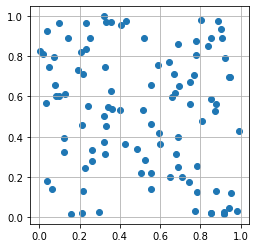

In [28]:
# Network weights visualization
kohonen_network = KohonenNetwork(10, 10, 2, 0.1, EuclideanDistance)
weights = kohonen_network.weights.reshape(100, 2)
x = list(map(lambda x: x[0], weights))
y = list(map(lambda x: x[1], weights))

plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x, y)
plt.grid(True)

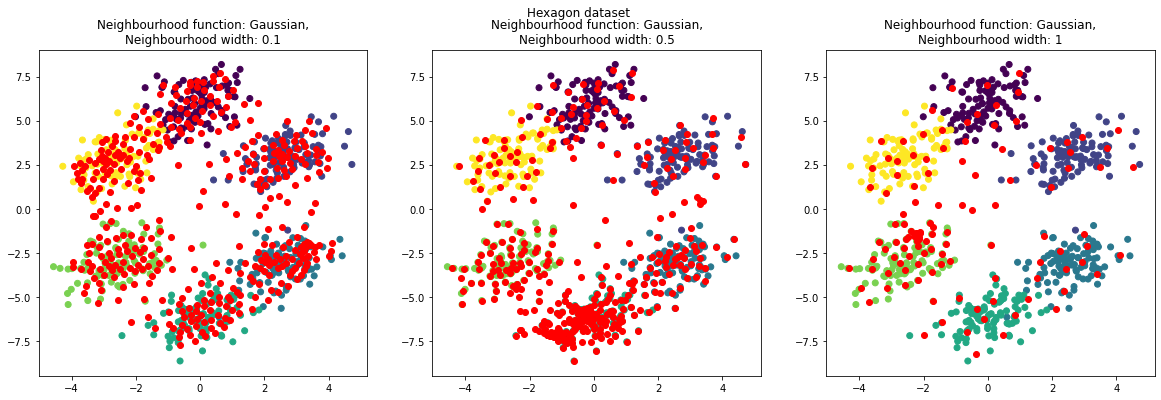

In [16]:
# settings #
neigh_widths = [0.1, 0.5, 1]

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Hexagon dataset')
m, n = 20, 20

col = -1
for neigh_width in neigh_widths:
    col += 1
    # train network
    kohonen_network = KohonenNetwork(m, n, 2, neigh_width, EuclideanDistance)
    kohonen_network.train(hexagon_train, 10, Gaussian.calculate, DecayFunction.calculate)
    # plot results
    ax[col].scatter(hexagon.x, hexagon.y, c = hexagon.c) 
    ax[col].set_title('Neighbourhood function: ' + Gaussian.__name__  + 
                      ',\nNeighbourhood width: ' + str(neigh_width))
    ax[col].scatter(
        kohonen_network.weights[:, :, 0].reshape(1, -1)[0],
        kohonen_network.weights[:, :, 1].reshape(1, -1)[0],
        c="red")

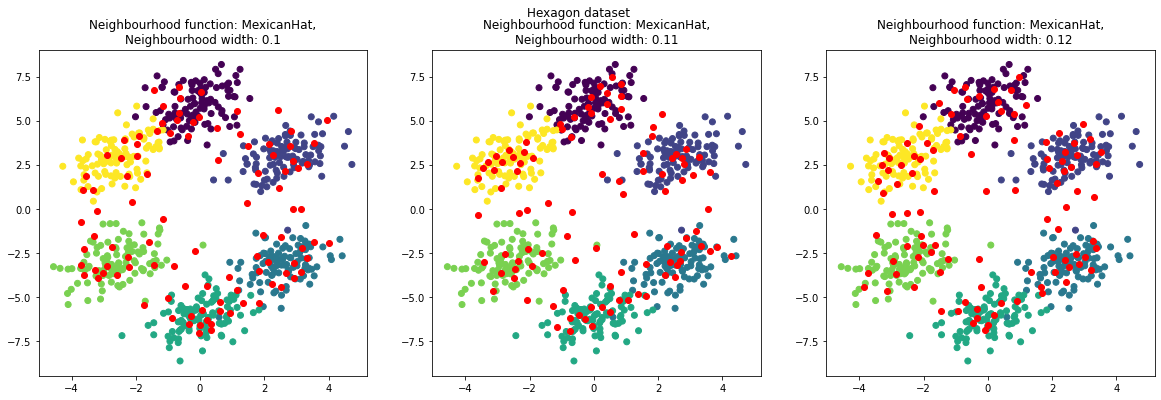

In [6]:
# settings #
neigh_widths = [0.1, 0.11, 0.12]

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Hexagon dataset')
m, n = 10, 10
col = -1
for neigh_width in neigh_widths:
    col += 1
    # train network
    kohonen_network = KohonenNetwork(m, n, 2, neigh_width, EuclideanDistance)
    kohonen_network.train(hexagon_train, 10, MexicanHat.calculate, DecayFunction.calculate)
    # plot results
    ax[col].scatter(hexagon.x, hexagon.y, c = hexagon.c) 
    ax[col].set_title('Neighbourhood function: ' + MexicanHat.__name__  +
                      ',\nNeighbourhood width: ' + str(neigh_width))
    ax[col].scatter(
        kohonen_network.weights[:, :, 0].reshape(1, -1)[0],
        kohonen_network.weights[:, :, 1].reshape(1, -1)[0],
        c="red")

### Cube dataset 

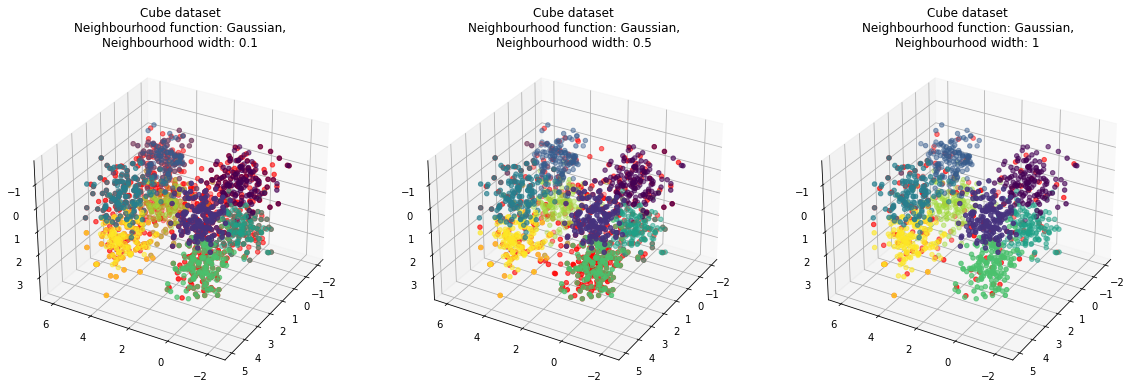

In [7]:
# settings #
fig = plt.figure(figsize = (20, 12))
m, n = 34, 34
neigh_widths = [0.1, 0.5, 1]

col = 0
for neigh_width in neigh_widths:
    col += 1
    # train network
    kohonen_network = KohonenNetwork(m, n, 3, neigh_width, EuclideanDistance)
    kohonen_network.train(cube_train, 10, Gaussian.calculate, DecayFunction.calculate)
    # plot results
    ax = fig.add_subplot(1, 3, col, projection='3d')
    ax.set_title('Cube dataset\nNeighbourhood function: ' + Gaussian.__name__  + 
                     ',\nNeighbourhood width: ' + str(neigh_width))
    ax.scatter(cube.x, cube.y, cube.z, c = cube.c);
    ax.scatter(
        kohonen_network.weights[:, :, 0].reshape(1, -1)[0],
        kohonen_network.weights[:, :, 1].reshape(1, -1)[0],
        kohonen_network.weights[:, :, 2].reshape(1, -1)[0],
        c="red")
    ax.view_init(-150, 150)

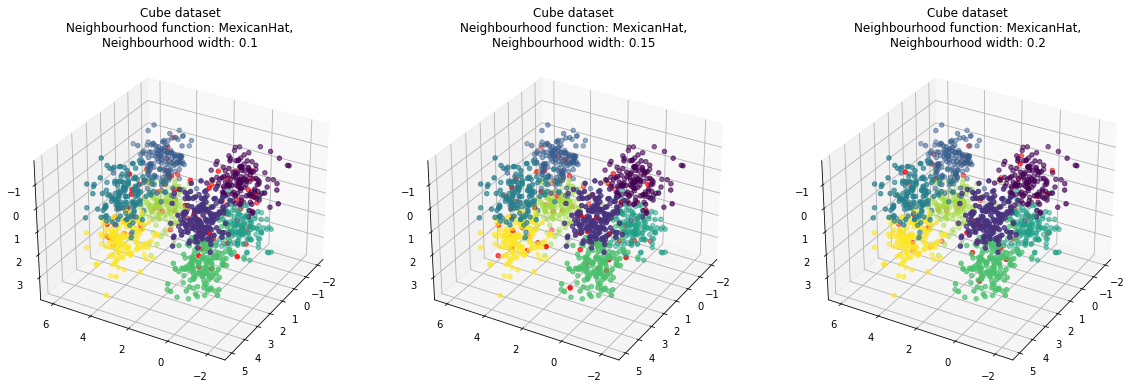

In [57]:
fig = plt.figure(figsize = (20, 12))
m, n = 10, 10
neigh_widths = [0.1, 0.15, 0.2]

col = 0
for neigh_width in neigh_widths:
    col += 1
    # train network
    kohonen_network = KohonenNetwork(m, n, 3, neigh_width, EuclideanDistance)
    kohonen_network.train(cube_train, 10, MexicanHat.calculate, DecayFunction.calculate)
    # plot results
    ax = fig.add_subplot(1, 3, col, projection='3d')
    ax.set_title('Cube dataset\nNeighbourhood function: ' + MexicanHat.__name__  + 
                     ',\nNeighbourhood width: ' + str(neigh_width))
    ax.scatter(cube.x, cube.y, cube.z, c = cube.c);
    ax.scatter(
        kohonen_network.weights[:, :, 0].reshape(1, -1)[0],
        kohonen_network.weights[:, :, 1].reshape(1, -1)[0],
        kohonen_network.weights[:, :, 2].reshape(1, -1)[0],
        c="red")
    ax.view_init(-150, 150)